In [87]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightAircraft.C172FBW

using ControlSystems
using RobustAndOptimalControl

In [88]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics
ac.airframe.pld.u.m_pilot = 75
ac.airframe.pld.u.m_copilot = 75
ac.airframe.pld.u.m_lpass = 0
ac.airframe.pld.u.m_rpass = 0
ac.airframe.pld.u.m_baggage = 0

trim_params = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = linearize!(ac; trim_params)

u_lon_labels = [:throttle_cmd, :elevator_cmd]
x_lon_labels = [:q, :θ, :v_x, :v_z, :α_filt, :ω_eng, :thr_v, :thr_p, :ele_v, :ele_p]
y_lon_labels = [:q, :θ, :α, :TAS, :f_x, :f_z, :γ, :ω_eng]

long_dyn_lss = filter(lm; u = u_lon_labels, x = x_lon_labels, y = y_lon_labels)

#the open-loop system, with throttle and elevator commands as inputs is our
#baseline plant
thr_ele_MIMO = named_ss(ss(long_dyn_lss), x = x_lon_labels, y = y_lon_labels, u = u_lon_labels)

NamedStateSpace{Continuous, Float64}
A = 
 -5.2415078407598115  -4.2624104024287235e-6   0.1282731557237412    -4.2457080907448015     151.56674416952862    0.004586547988911682      0.0                   0.0                0.0                  13.832378046579663
  0.999999432975347   -8.384607133379394e-14   1.577200277092198e-7   5.5290881593573295e-9    0.0                 0.0                       0.0                   0.0                0.0                   0.0
  1.2076773158225365  -9.771182551776917      -0.15218133231600847    2.491794763561461      -86.38415929055182    0.017428813657360463      0.0                   0.0                0.0                  -7.360027503935953
 48.17167828482101    -0.34253081547871034    -0.2754599805153237    -3.3570819577146938      43.44913261627488    0.00044858180103699225    0.0                   0.0                0.0                   5.628518572002491
  0.0                  0.0                    -0.035034460002611345   0.999386090808

## 1. Pitch Rate

In [89]:
e2q = thr_ele_MIMO[:q, :elevator_cmd]

zpk(e2q) |> display
poles(e2q) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                 (1.0s + 49.62372606776288)(1.0s + 10.861904551736702)(1.0s + 1.9903244326618692)(1.0s + 2.9165802025754738e-5)(1.0s + 0.05292261602457189)
54608.03969842179-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 47.3941085464061)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s + 10.86410802114631)(1.0s^2 + 11.272641304507173s + 75.79770968112544)(1.0s^2 + 0.03542593744879723s + 0.0610502754084123)

Continuous-time transfer function model

10-element Vector{ComplexF64}:
    -47.39410854640622 + 0.0im
   -10.864108021146302 + 0.0im
    -5.636320652253582 + 6.635480328213257im
    -5.636320652253582 - 6.635480328213257im
 -0.017712968724395883 + 0.24644781627634882im
 -0.017712968724395883 - 0.24644781627634882im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

We have:
- Two pairs of very fast imaginary poles, corresponding to the throttle and elevator actuators
- A pair of fast imaginary poles, corresponding to the short period mode
- A pair of slow imaginary poles, corresponding to the phugoid mode
- A very fast real pole, corresponding to the AoA filter
- A fast real pole, corresponding to the powerplant response (in particular, the propeller moment of inertia)

In [90]:
#error transfer function for a unit feedback closed loop and a unit step input
ε_e2q_cl = 1/(1+tf(e2q))
poles(ε_e2q_cl) |> display
#since all closed loop poles are stable, we can apply the final value theorem to
#find the steady-state error with for the unit feedback closed loop plant.
@show ε_e2q_cl(0)

10-element Vector{ComplexF64}:
  -37.699111843077354 + 50.26548245743458im
  -37.699111843077354 - 50.26548245743458im
  -26.667275801103507 + 46.880507004732216im
  -26.667275801103507 - 46.880507004732216im
  -44.253942934148334 + 0.0im
   -31.66409273131005 + 0.0im
  -10.860090400631591 + 0.0im
   -4.815701695690689 + 0.0im
 -0.01806406583806018 + 0.20928056249747098im
 -0.01806406583806018 - 0.20928056249747098im

ε_e2q_cl(0) = [0.999990386865314;;]


1×1 Matrix{Float64}:
 0.999990386865314

The steady state error is finite, but very close to 1. This is because, while the open loop TF is type 0, due to its zero very close to the origin, in practice it has nearly derivative action. 

Therefore, although the integrator in a PID compensator would in theory yield a type 1 system (and zero steady state error for step inputs), in practice (for reasonable time windows) the system will still behave as a type 0. So, for satisfactory steady-state behavior, we need a pure integrator in the feedforward path in addition to the PID.

1×1 Matrix{Float64}:
 0.0

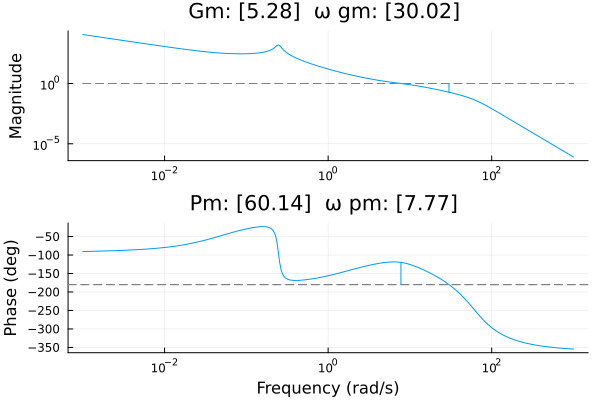

In [130]:
#less agressive design
# k_p = 3.8
# k_i = 20
# k_d = 0.29
# τ_d = 0.05

#pitch rate compensator PID
# k_p_q = 5.2
# k_i_q = 25
# k_d_q = 0.45
# τ_d_q = 0.04

#pitch rate compensator PID
k_p_q = 4.8
k_i_q = 35
k_d_q = 0.6
τ_d_q = 0.04

#compensator is an integrator in series with the PID
qcmp_tf = tf(1, [1, 0]) * (k_p_q + k_i_q * tf(1, [1,0]) + k_d_q * tf([1, 0], [τ_d_q, 1]))

#input to the pitch rate compensator is pitch rate error, output is
#elevator_cmd, which feeds into e2q
qcmp = named_ss(ss(qcmp_tf), :qcmp; u = :q_err, y = :elevator_cmd)
qcmp_e2q = series(qcmp, e2q)

#steady-state error for a unit step input, now zero
ε_qcmp_e2q_cl = 1/(1+tf(qcmp_e2q))
ε_qcmp_e2q_cl(0) |> display

marginplot(qcmp_e2q) 

StepInfo:
Initial value:     0.000
Final value:       0.997
Step size:         0.997
Peak:              1.157
Peak time:         0.348 s
Overshoot:         16.04 %
Undershoot:         0.00 %
Settling time:     1.351 s
Rise time:         0.129 s


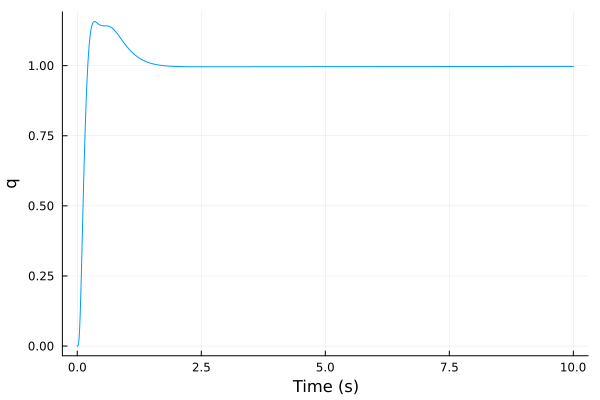

In [131]:
qcmp_e2q_cl = feedback(qcmp_e2q)
qcmp_e2q_cl_step = step(qcmp_e2q_cl, 10)

# poles(minreal(qcmp_e2q_cl, 1e-3)) |> display
stepinfo(qcmp_e2q_cl_step) |> display
qcmp_e2q_cl_step |> plot


Now we have a SISO compensator design, we need to use it to close the loop in the MIMO plant.

First, we will do it manually. The baseline MIMO system has two inputs, throttle_cmd and elevator_cmd. Our SISO compensator receives q_err as an input and outputs elevator_cmd. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive [throttle_cmd, q_err] as input and output [throttle_cmd, elevator_cmd]. Therefore, it must apply an unit gain to its first input throttle_cmd to let it pass through unchanged, and apply the SISO compensator to its second input q_err to obtain elevator_cmd.

The setpoint vector to be applied to the closed-loop MIMO system is r = [throttle_cmd, q_dmd]. The input to the MIMO compensator must be u = [throttle_cmd, q_err] = r - f = [throttle_cmd, q_dmd] - [0, q]. So we need a matrix gain that premultiplies the 7-component output vector of thr_ele_MIMO, and produces a 2-component vector [0, q]. This will be a 2xNy matrix K_q with all entries set to zero except K_q[2, 1] (the nonzero output goes in the second component, and it is q, the first element in thr_ele_MIMO's output vector)

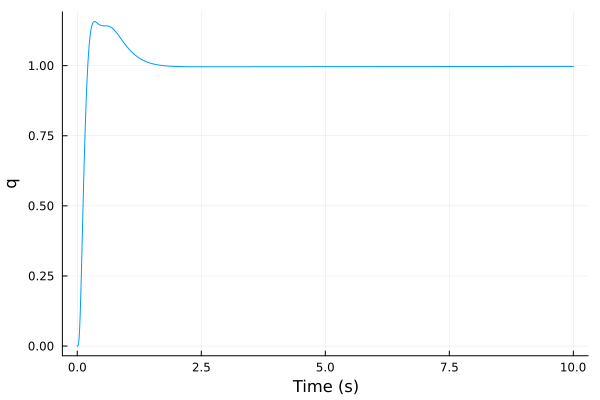

In [132]:
#create a diagonal MIMO system with a unit feedthrough system and the pitch
#rate compensator
qcmp_MIMO = append(ss(1.0), ss(qcmp))
#prepend it to the plant
qcmp_thr_ele_MIMO = series(qcmp_MIMO, ss(thr_ele_MIMO))

#construct feedback system K_q_ss
K_q = zeros(2, 8)
K_q[2,1] = 1 #selects q from thr_ele_MIMO and puts it in the second row
K_q_ss = ss(K_q) #creates a ss with no dynamics and K_q as feedthrough

#create a feedback loop with K_q_ss in the feedback path
thr_q_MIMO_man = feedback(qcmp_thr_ele_MIMO, K_q_ss)

#finally, convert it to a NamedStateSpace with the appropriate labels
thr_q_MIMO_man = named_ss(thr_q_MIMO_man, :thr_q, u = [:throttle_cmd, :q_dmd], y = y_lon_labels)

#check we get the same response as with the SISO closed loop
qdmd2q_man = thr_q_MIMO_man[:q, :q_dmd]
step(qdmd2q_man, 10) |> plot

All this is made much more straightforward by the connect function from RobustAndOptimalControl.jl

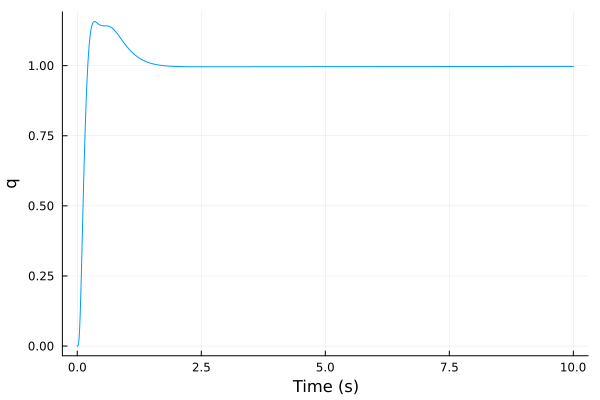

In [133]:
qsum = sumblock("q_err = q_dmd - q")
thr_q_MIMO = connect([qsum, qcmp, thr_ele_MIMO], [:q_err=>:q_err, :q=>:q, :elevator_cmd=>:elevator_cmd], w1 = [:throttle_cmd, :q_dmd], z1 = y_lon_labels)

#verify we get the same response as with the SISO closed loop
qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(qdmd2q, 10) |> plot 

#thr_q_MIMO is our new plant baseline: longitudinal dynamics with embedded pitch
#rate control and throttle_cmd and q_dmd as inputs

## 2. Pitch Angle

The starting plant is the longitudinal dynamics augmented with embedded pitch rate control.

13-element Vector{ComplexF64}:
  -37.699111843076395 + 50.26548245742803im
  -37.699111843076395 - 50.26548245742803im
   -39.87289779073373 + 49.08211614601601im
   -39.87289779073373 - 49.08211614601601im
   -47.86333627926355 + 0.0im
   -7.688426236521883 + 10.387396401386106im
   -7.688426236521883 - 10.387396401386106im
   -10.84482071950111 + 0.0im
    -8.77622428427279 + 0.0im
   -3.204698846041265 + 2.9236761965915132im
   -3.204698846041265 - 2.9236761965915132im
  -0.8951126374354036 + 0.0im
 -0.05296782860328458 + 0.0im

ε_qdmd2θ_cl(0) = [2.914877182685252e-5;;]


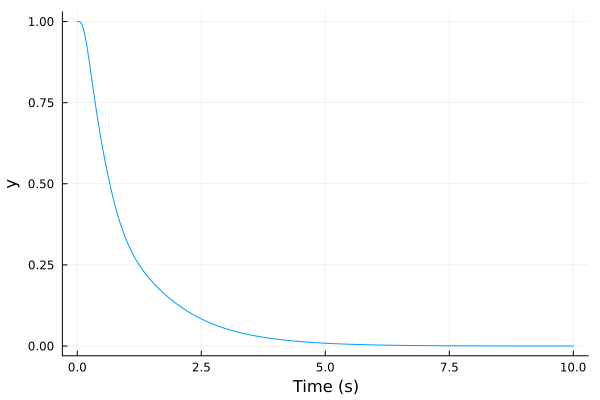

In [134]:
qdmd2θ = thr_q_MIMO[:θ, :q_dmd]
#error transfer function for a unit feedback closed loop and a unit step input
ε_qdmd2θ_cl = 1/(1+tf(qdmd2θ))
poles(ε_qdmd2θ_cl) |> display
#final value theorem to find steady-state error
@show ε_qdmd2θ_cl(0)
step(ε_qdmd2θ_cl, 10) |> plot 

The steady-state error for a step input is essentially zero, so the plant behaves like a type 1 transfer function. Therefore, it appears we won't need integral action in the feedforward path. However, this is only true for the symmetric, wings-level condition in which the linearized plant model was obtained, where $\theta$ is a pure integral of $q$. To achieve zero steady-state error in the more general turning flight condition we will need integral action in the $\theta$ control loop as well.

The reason is that a steady-state turn requires a non-zero pitch rate. In $\theta$ control mode, the pitch rate demand will come from the $\theta$ controller. If the controller is purely proportional, the only mechanism by which it can generate a steady-state pitch rate command is the existence of a nonzero steady-state $\theta$ error. Therefore, the pitch rate required by a steady-state turn is only feasible with a non-zero error in $\theta$.

A potential solution would be to introduce a feedforward element that generates the pitch rate command required for the turn, which would be added to that generated by the $\theta$ compensator to track the commanded $\theta$. But a simpler, more robust solution is simply to introduce an integral control term in the $\theta$ compensator. We must be careful with stability margins; at this point the overall $\theta$ control path will already contain three integrators in series.

ε_θcmp_qdmd2θ_cl(0) = [0.0;;]


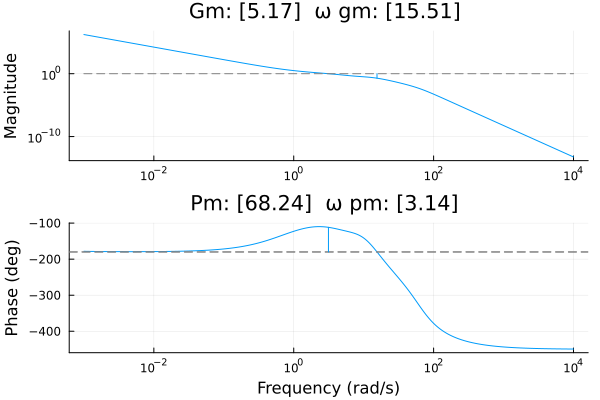

In [135]:
#design using PID derivative term
k_p_θ = 2.5
k_i_θ = 1.7
k_d_θ = 0.18
τ_d_θ = 0.04

#design using actual pitch rate feedback
# k_p_θ = 4.2
# k_i_θ = 3.6
# k_d_θ = 0.5
# τ_d_θ = 0.002 #REPLACE D-TERM WITH ACTUAL PITCH RATE FEEDBACK

θcmp_tf = k_p_θ + k_i_θ * tf(1, [1,0]) + k_d_θ * tf([1, 0], [τ_d_θ, 1])

#input to the theta compensator is theta error, output is q_dmd, which feeds
#into qdmd2q
θcmp = named_ss(ss(θcmp_tf), :θcmp; u = :θ_err, y = :q_dmd)

θcmp_qdmd2θ = series(θcmp, qdmd2θ)

#unit feedback steady-state error for a unit step input, now zero
ε_θcmp_qdmd2θ_cl = 1/(1+tf(θcmp_qdmd2θ))
@show ε_θcmp_qdmd2θ_cl(0)

marginplot(θcmp_qdmd2θ) 

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.112
Peak time:         1.639 s
Overshoot:         11.19 %
Undershoot:         0.00 %
Settling time:     4.294 s
Rise time:         0.387 s


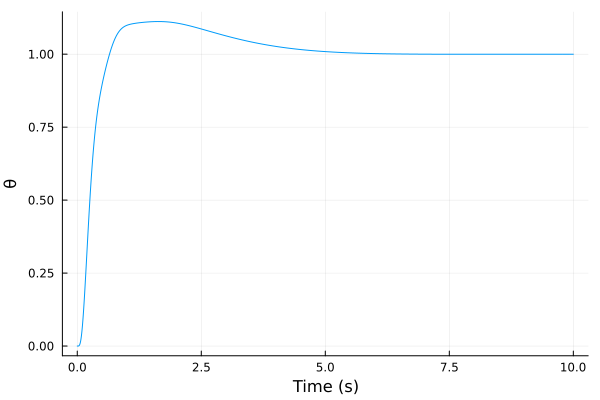

In [136]:
θcmp_qdmd2θ_cl = feedback(θcmp_qdmd2θ)
θcmp_qdmd2θ_cl_step = step(θcmp_qdmd2θ_cl, 10)

# poles(minreal(θcmp_qdmd2θ_cl, 1e-3)) |> display
stepinfo(θcmp_qdmd2θ_cl_step) |> display
θcmp_qdmd2θ_cl_step |> plot

For this design, we are considering an unreasonably small derivative filter constant. This is because that in the implementation of the $\theta$ compensator we will not rely on the filtered derivative term from the PID, but directly on the actual pitch rate, which is of course available.

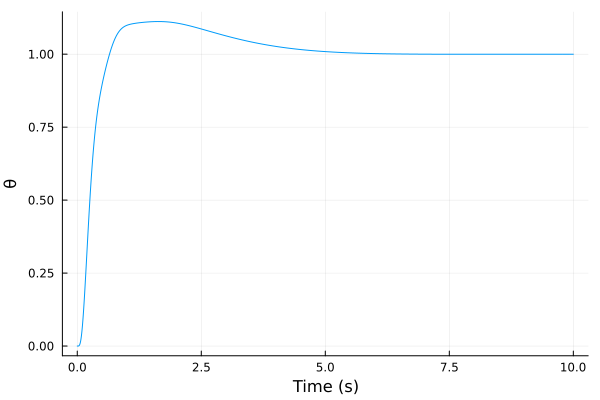

In [137]:
θsum = sumblock("θ_err = θ_dmd - θ")
thr_θ_MIMO = connect([θsum, θcmp, thr_q_MIMO], [:θ_err=>:θ_err, :θ=>:θ, :q_dmd=>:q_dmd], w1 = [:throttle_cmd, :θ_dmd], z1 = y_lon_labels)

#check we get the same response as with the SISO closed loop
θdmd2θ = thr_θ_MIMO[:θ, :θ_dmd]
step(θdmd2θ, 10) |> plot 

## 3. TAS to Throttle

We can reasonably assume that autothrottle will be used together with some form of $\theta$ control, be it manual or automatic. Thus, we start from the plant with closed-loop $\theta$ control. This scenario corresponds for example to the pitch angle, climb rate and altitude hold modes, in which automatic $\theta$ control will be enabled, with $\theta$ demands supplied either directly or by the climb rate loop.

In [138]:
t2v = thr_θ_MIMO[:TAS, :throttle_cmd]

zpk(t2v) |> display
poles(t2v) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                    (1.0s^2 + 80.4444442704983s + 4042.2652392077907)(1.0s + 47.31083220776303)(1.0s + 28.798735790264235)(1.0s^2 + 14.137077723860829s + 232.08050526734502)(1.0s + 6.093302647922396)(1.0s^2 + 6.139739332032517s + 25.994606397385496)(1.0s^2 + 1.885740283549187s + 1.1276538963575655)
81183.02209930406----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 47.774504848535166)(1.0s^2 + 79.76213962418296s + 4026.2682024851847)(1.0s^2 + 75.39822368615498s + 3947.8417604357387)(1.0s + 28.6436050319707)(1.0s

15-element Vector{ComplexF64}:
  -39.88106981209148 + 49.35350517570429im
  -39.88106981209148 - 49.35350517570429im
 -47.774504848535166 + 0.0im
   -28.6436050319707 + 0.0im
  -6.071996212869461 + 11.634749594832925im
  -6.071996212869461 - 11.634749594832925im
 -10.855975182727514 + 0.0im
  -7.244809293519497 + 0.0im
 -3.3009049547164326 + 3.8704351683296774im
 -3.3009049547164326 - 3.8704351683296774im
 -0.9423598248777807 + 0.4899044803851767im
 -0.9423598248777807 - 0.4899044803851767im
 -0.0529515298002153 + 0.0im
  -37.69911184307749 + 50.26548245743667im
  -37.69911184307749 - 50.26548245743667im

In [139]:
#error transfer function for a unit feedback closed loop and a unit step input
ε_t2v_cl = 1/(1+tf(t2v))
poles(ε_t2v_cl) |> display
#all closed loop poles are stable, final value theorem
@show ε_t2v_cl(0)

15-element Vector{ComplexF64}:
  -39.84458624812928 + 49.36369228315589im
  -39.84458624812928 - 49.36369228315589im
   -37.9363337076454 + 50.15770758303364im
   -37.9363337076454 - 50.15770758303364im
  -47.76647072765755 + 0.0im
 -28.652981375790336 + 0.0im
  -5.955041650917805 + 11.248355324256158im
  -5.955041650917805 - 11.248355324256158im
  -7.563861791073575 + 3.2890634019635847im
  -7.563861791073575 - 3.2890634019635847im
 -3.1634373560825906 + 3.5194446129552026im
 -3.1634373560825906 - 3.5194446129552026im
  -3.129306224664858 + 0.0im
 -0.9437256730060519 + 0.488060239910809im
 -0.9437256730060519 - 0.488060239910809im

ε_t2v_cl(0) = [0.023982688250599137;;]


1×1 Matrix{Float64}:
 0.023982688250599137

ε_vtcmp_t2v_cl(0) = [0.0;;]


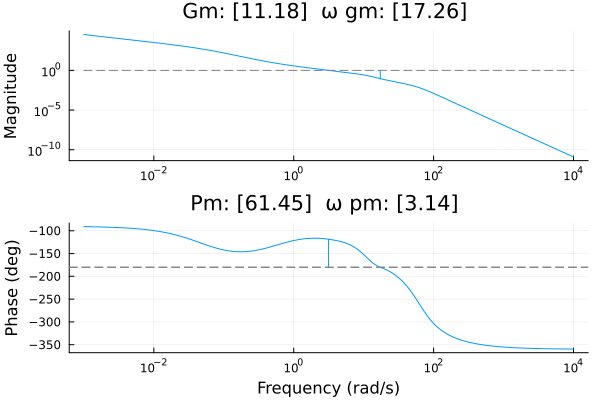

In [140]:
#we don't want the response to be too eager. and in theory we should only need a
#smidge of integration to get rid of steady state error. however, in simulation
#we find that the integrator needs some more punch to reject the effects of
#altitude changes, etc

# k_p_vt = 0.2
# k_i_vt = 0.01
# k_d_vt = 0.0
# τ_d_vt = 0.04
k_p_vt = 1.5
k_i_vt = 0.8
k_d_vt = 0.0
τ_d_vt = 0.04

vtcmp_tf = k_p_vt + k_i_vt * tf(1, [1,0]) + k_d_vt * tf([1, 0], [τ_d_vt, 1])

#input to the theta compensator is TAS error, output is throttle_cmd
vtcmp = named_ss(ss(vtcmp_tf), :vtcmp; u = :TAS_err, y = :throttle_cmd)
vtcmp_t2v = series(vtcmp, t2v)

#unit feedback steady-state error for a unit step input, now zero
ε_vtcmp_t2v_cl = 1/(1+tf(vtcmp_t2v))
@show ε_vtcmp_t2v_cl(0)

marginplot(vtcmp_t2v) 

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.133
Peak time:         1.060 s
Overshoot:         13.26 %
Undershoot:         0.00 %
Settling time:     3.975 s
Rise time:         0.361 s


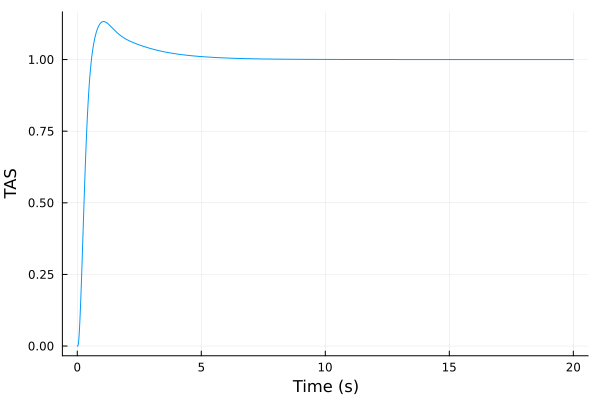

In [141]:
vtcmp_t2v_cl = feedback(vtcmp_t2v)
vtcmp_t2v_cl_step = step(vtcmp_t2v_cl, 20)

# poles(minreal(θcmp_qdmd2θ_cl, 1e-3)) |> display
stepinfo(vtcmp_t2v_cl_step) |> display
vtcmp_t2v_cl_step |> plot

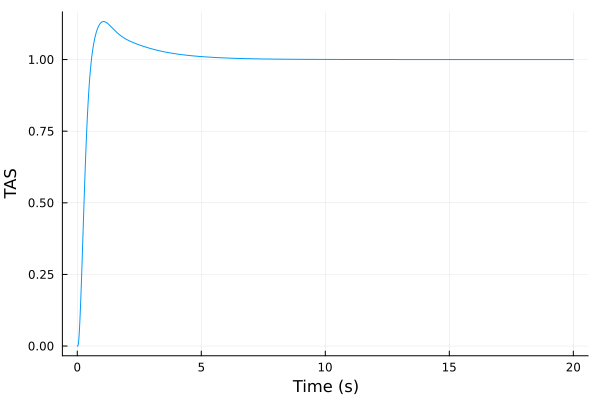

In [142]:
TASsum = sumblock("TAS_err = TAS_dmd - TAS")
vt_θ_MIMO = connect([TASsum, vtcmp, thr_θ_MIMO], [:TAS_err=>:TAS_err, :TAS=>:TAS, :throttle_cmd=>:throttle_cmd], w1 = [:TAS_dmd, :θ_dmd], z1 = y_lon_labels)

#check we get the same response as with the SISO closed loop
TASdmd2TAS = vt_θ_MIMO[:TAS, :TAS_dmd]
step(TASdmd2TAS, 20) |> plot 